# Dipole
This example reproduces the topology constraint.

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from quadcoil import quadcoil, tree_len

from simsopt.mhd import Vmec
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve
import jax
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Loading files

In [2]:
# Loading muse++ equilibrium into VMEC
# filename_pp = "wout_muse++.nc"
# equil_pp = Vmec(filename_pp, keep_all_files=True)
# plasma_surface = equil_pp.boundary
# net_poloidal_current_amperes = equil_pp.external_current()

# Loading NCSX
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
jax.config.update('jax_enable_x64', False)

# Problem settings

In [3]:
# Settings 
separation = 0.1
mpol = 12
ntor = 12
nfp = plasma_surface.nfp
plasma_M_theta = 16
plasma_N_phi = 32

## Running a REGCOIL scan

In [4]:
if not os.path.exists('regcoil.npy'):
    # We scan the REGCOIL regularization factor and recover the 
    # dipole distribution Caoxiang's paper chose
    f_B_test_list = []
    phi_test_list = []
    f_K_test_list = []
    time_quadcoil_list = []
    time_regcoil_list = []
    phi_ans_list = []
    f_B_ans_list = []
    f_K_ans_list = []
    for i in jnp.append(10**np.linspace(-10, -20, 20), 0.):
        # Run QUADCOIL first
        time1 = time.time()
        regcoili_out_dict, regcoili_qp, regcoil1_dofs, status = quadcoil(
            nfp=plasma_surface.nfp,
            stellsym=plasma_surface.stellsym,
            mpol=mpol,
            ntor=ntor,
            plasma_dofs=plasma_surface.get_dofs(),
            plasma_mpol=plasma_surface.mpol,
            plasma_ntor=plasma_surface.ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            plasma_coil_distance=separation,
            objective_name=('f_B', 'f_K'),
            objective_weight=np.array([1., i]),
            objective_unit=(1., 1.),
            metric_name=('f_B', 'f_K'),
        )
    
        phi_test_list.append(regcoil1_dofs)
        f_B_test_list.append(regcoili_out_dict['f_B']['value'])
        f_K_test_list.append(regcoili_out_dict['f_K']['value'])
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('i =', i, '| time =', time2-time1)
    
        wsi = regcoili_qp.winding_surface.to_simsopt()
        psi = regcoili_qp.plasma_surface.to_simsopt()
        cpi = CurrentPotentialFourier(
            wsi, mpol=mpol, ntor=ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            stellsym=True)
        cpsti = CurrentPotentialSolve(cpi, psi, 0)
        regcoil1_dofs_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(i)
        time2 = time.time()
        time_regcoil_list.append(time2-time1)
        phi_ans_list.append(regcoil1_dofs_ans)
        f_B_ans_list.append(regcoili_f_B_ans)
        f_K_ans_list.append(regcoili_f_K_ans)
        
    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    print('REGCOIL avg time:', np.average(time_regcoil_list), '(s)')
    print('REGCOIL max time:', np.max(time_regcoil_list), '(s)')
    time_regcoil_list = np.array(time_regcoil_list)
    phi_ans_list = np.array(phi_ans_list)
    f_B_ans_list = np.array(f_B_ans_list)
    f_K_ans_list = np.array(f_K_ans_list)
    time_quadcoil_list = np.array(time_quadcoil_list)
    phi_test_list = np.array(phi_test_list)
    f_B_test_list = np.array(f_B_test_list)
    f_K_test_list = np.array(f_K_test_list)
    jnp.save('regcoil.npy',{
        'regcoili_qp': regcoili_qp,
        'time_regcoil_list': time_regcoil_list,
        'phi_ans_list': phi_ans_list,
        'f_B_ans_list': f_B_ans_list,
        'f_K_ans_list': f_K_ans_list,
        'time_quadcoil_list': time_quadcoil_list,
        'phi_test_list': phi_test_list,
        'f_B_test_list': f_B_test_list,
        'f_K_test_list': f_K_test_list,
    })
    # Is quadcoil really well-behaved than regcoil?
    print('Quadcoil seems to be more well-behaved than regcoil.')    
    from quadcoil.quantity import f_B
    print('quadcoil f_B', f_B(regcoili_qp, phi_test_list[0]))
    print('regcoil  f_B', f_B(regcoili_qp, phi_ans_list[0]))
    plt.plot(phi_test_list[0], label='regcoil')
    plt.plot(phi_ans_list[0], label='quadcoil', linestyle='dashed')
    plt.legend()
    plt.show()
else:
    dict = jnp.load('regcoil.npy', allow_pickle=True).item()
    regcoili_qp = dict['regcoili_qp']
    time_regcoil_list = dict['time_regcoil_list']
    phi_ans_list = dict['phi_ans_list']
    f_B_ans_list = dict['f_B_ans_list']
    f_K_ans_list = dict['f_K_ans_list']
    time_quadcoil_list = dict['time_quadcoil_list']
    phi_test_list = dict['phi_test_list']
    f_B_test_list = dict['f_B_test_list']
    f_K_test_list = dict['f_K_test_list']

f_K at the inflection point: 27605936000000.0
f_B at the inflection point: 0.0010883488


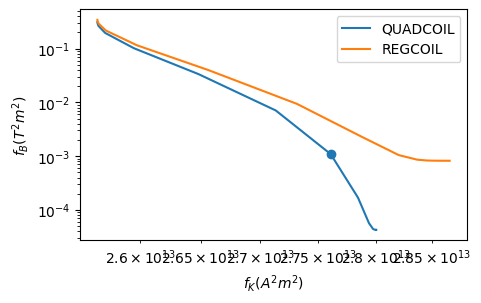

In [5]:
# inflection point
i_infl = 8 # np.argmin(f_K_test_list * f_B_test_list)
plt.figure(figsize=(5,3))
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('$f_B(T^2m^2)$')
plt.xlabel('$f_K(A^2m^2)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

## Dipole layer thickness optimization
Here, we constrain the field error, and target the maximum 
magnitude of the dipole density over the surface

In [6]:
# Calculating normalization factors
from quadcoil.quantity import f_max_Phi2, f_B, f_max_Phi, Phi, f_l1_Phi, f_max_Phi4
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi4 = f_max_Phi4(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^4) =', unit_Phi4, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')
unit_l1 = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
print('||Phi||1) =', unit_l1, 'At the inflection point.')

Max(Phi^2) = 88738900000.0 At the inflection point.
Max(Phi^4) = 7.874592e+21 At the inflection point.
Max(Phi) = 297890.75 At the inflection point.
||Phi||1) = 2661151.0 At the inflection point.


In [7]:
time1=time.time()
# Solving with the quadcoil default function
out_dict, qp, dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    phi_mn_init=phi_test_list[i_infl]['phi'],
    objective_name='f_max_Phi', # Minimizing peak dipole density
    objective_unit=unit_Phi, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    # value_only=True,
    fstop_inner=0.,
)
jax.block_until_ready(dofs)
time2=time.time()
print('time:', time2-time1)# Run your function

2025-05-13 13:58:09.309867: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace


time: 35.1587815284729


2025-05-13 13:58:44.503889: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace


f_B from REGCOIL:       0.0010883488
f_B from QUADCOIL:      0.001088319
Max dipole dens from REGCOIL:       297890.75
Max dipole dens from QUADCOIL:      269561.06 9.51 % improvement


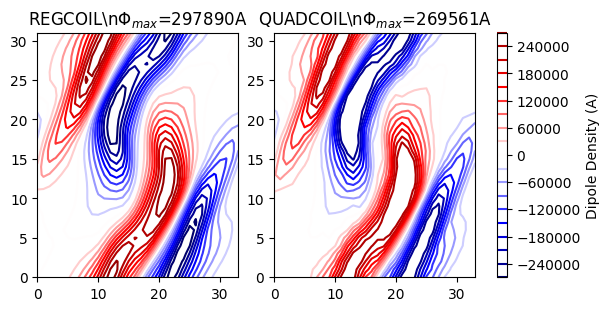

In [8]:
dofs_regcoil = phi_test_list[i_infl]
print('f_B from REGCOIL:      ', f_B(regcoili_qp, dofs_regcoil))
print('f_B from QUADCOIL:     ', f_B(qp, dofs))
f_Phi_ctrl = f_max_Phi(regcoili_qp,dofs_regcoil)
f_Phi_1 = f_max_Phi(qp, dofs)
print('Max dipole dens from REGCOIL:      ', f_Phi_ctrl)
print('Max dipole dens from QUADCOIL:     ', f_Phi_1, round((f_Phi_ctrl-f_Phi_1)/f_Phi_ctrl*100, 3), '% improvement')

phi_regcoil = Phi(qp, dofs_regcoil)
phi_quadcoil = Phi(qp, dofs)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title(r'REGCOIL\n$\Phi_{max}$='+str(int(f_Phi_ctrl))+'A')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title(r'QUADCOIL\n$\Phi_{max}$='+str(int(f_Phi_1))+'A')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


## Dipole sparsity optimization
Here, we constrain the field error and maximum dipole density, 
and target the L-1 norm of the dipole over the surface.

In [9]:
f_Phi_ctrl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])

In [10]:
# Solving with the quadcoil default function
time1 = time.time()
l1_out_dict, l1_qp, l1_dofs, l1_status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_B',
    objective_name='f_l1_Phi', # Minimizing the L1 norm of Phi
    objective_unit=unit_l1, # under an f_B, max Phi constraint
    constraint_name=('f_B', 'f_max_Phi',),
    constraint_type=('<=', '<=',),
    constraint_unit=(f_B_target, f_Phi_ctrl,),
    constraint_value=np.array([f_B_target, f_Phi_ctrl,]),
    value_only=True
    # verbose=3,
    # **numerical_kwargs
)
time2 = time.time()
print(time2-time1)

TypeError: unsupported operand type(s) for -: 'DynamicJaxprTracer' and 'NoneType'

In [ ]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(l1_qp, l1_dofs))
f_l1_Phi_crtl = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
f_l1_Phi_l1 = f_l1_Phi(l1_qp, l1_dofs)
print('Max dipole dens from REGCOIL:      ', f_l1_Phi_crtl)
print('Max dipole dens from QUADCOIL:     ', f_l1_Phi_l1, round((f_l1_Phi_crtl-f_l1_Phi_l1)/f_l1_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(regcoili_qp, phi_test_list[i_infl])
phi_quadcoil_l1 = Phi(l1_qp, l1_dofs)
cmin = np.min([phi_regcoil, phi_quadcoil_l1])
cmax = np.max([phi_regcoil, phi_quadcoil_l1])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil_l1, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


### Cumulative distribution function plot
This plot shows the proportion of grid points 
with dipole density $\leq x\% \Phi_{max}$.

In [11]:

# Flatten arrays
phi_reg = jnp.abs(phi_regcoil.flatten())
phi_quad = jnp.abs(phi_quadcoil_l1.flatten())

# Sort values
phi_reg_sorted = np.sort(phi_reg) / np.max(phi_reg) * 100
phi_quad_sorted = np.sort(phi_quad) / np.max(phi_reg) *100

# Compute CCDFs
ccdf_reg = np.arange(1, len(phi_reg_sorted)+1) / len(phi_reg_sorted)*100
ccdf_quad = np.arange(1, len(phi_quad_sorted)+1) / len(phi_quad_sorted)*100

# Plot
plt.figure(figsize=(5, 3))
plt.plot(phi_reg_sorted, ccdf_reg, label='REGCOIL', color='blue')
plt.plot(phi_quad_sorted, ccdf_quad, label='QUADCOIL', color='orange')
plt.xticks(np.linspace(0, 100, 11))
# Labels and legend
plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
plt.ylabel('CDF (% $\leq$ x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:20: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1415531/4046073013.py:19: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
/tmp/ipykernel_1415531/4046073013.py:20: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('CDF (% $\leq$ x)')
/tmp/ipykernel_1415531/4046073013.py:19: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
/tmp/ipykernel_1415531/4046073013.py:20: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('CDF (% $\leq$ x)')


NameError: name 'phi_quadcoil_l1' is not defined

In [11]:
i = jnp.linspace(-0.1, 0.1, 50)[0]
plasma_dof_i = plasma_surface.get_dofs().copy()
plasma_dof_i[0] *= (1 + i)
out_dict_i, qp_i, dofs_i, status_i = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_dof_i,
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name=('f_max_Phi', 'f_K', 'f_B'),
    objective_name='f_max_Phi', # Minimizing peak dipole density
    objective_unit=unit_Phi, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    verbose=0,
    # **numerical_kwargs
)
print('f_B!!!!!!!', f_B(qp_i, dofs_i))


KeyboardInterrupt

Exception ignored in: Traceback (most recent call last):
  File "_zmq.py", line 169, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt
'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "_zmq.py", line 169, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 


## Taylor test for dipole thickness optimization

In [9]:
plasma_dof_0_list = []
phi_test_list = []
f_max_Phi_test_list = []
f_max_Phi_diff_test_list = []
f_K_test_list = []
f_B_test_list = []
f_K_diff_test_list = []
time_quadcoil_list = []
time_regcoil_list = []
lam_list = []
mu_list = []
c_list = []
qp_list = []
for i in jnp.linspace(-0.1, 0.1, 50):
    plasma_dof_i = plasma_surface.get_dofs().copy()
    plasma_dof_i[0] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    out_dict_i, qp_i, dofs_i, status_i = quadcoil(
        nfp=plasma_surface.nfp,
        stellsym=plasma_surface.stellsym,
        plasma_coil_distance=separation,
        mpol=mpol,
        ntor=ntor,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=plasma_surface.mpol,
        plasma_ntor=plasma_surface.ntor,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=0.,
        metric_name=('f_max_Phi', 'f_K', 'f_B'),
        objective_name='f_max_Phi2', # Minimizing peak dipole density
        objective_unit=unit_Phi2, # under an f_B constraint
        constraint_name=('f_B',),
        constraint_type=('<=',),
        constraint_unit=(f_B_target,),
        constraint_value=np.array([f_B_target,]),
        # verbose=1,
        # **numerical_kwargs
    )
    qp_list.append(qp_i)
    print('f_B!!!!!!!', f_B(qp_i, dofs_i))
    block_until_ready(dofs_i)
    block_until_ready(out_dict_i)
    block_until_ready(qp_i)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    print('time:', time2-time1)
    # REGCOIL ---------------------------------------------------
    plasma_dof_0_list.append(plasma_dof_i[0])
    phi_test_list.append(dofs_i)
    f_max_Phi_test_list.append(out_dict_i['f_max_Phi']['value'])
    f_max_Phi_diff_test_list.append(out_dict_i['f_max_Phi']['grad']['df_dplasma_dofs'][0])
    f_K_test_list.append(out_dict_i['f_K']['value'])
    f_B_test_list.append(out_dict_i['f_B']['value'])
    f_K_diff_test_list.append(out_dict_i['f_K']['grad']['df_dplasma_dofs'][0])
    lam_list.append(status_i['inner_fin_lam'])
    mu_list.append(status_i['inner_fin_mu'])
    c_list.append(status_i['inner_fin_c'])
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')

2025-05-12 12:39:15.962472: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_quadcoil] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-12 12:40:19.268698: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 3m3.306376385s

********************************
[Compiling module jit_quadcoil] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


f_B!!!!!!! 0.0010884765
time: 207.169442653656
f_B!!!!!!! 0.0010883231
time: 1.538017988204956
f_B!!!!!!! 0.0010882723
time: 1.5091443061828613
f_B!!!!!!! 0.0010884423
time: 1.4631309509277344
f_B!!!!!!! 0.0010884979
time: 1.4728140830993652
f_B!!!!!!! 0.0010885427
time: 1.4665217399597168
f_B!!!!!!! 0.0010885288
time: 1.48679518699646
f_B!!!!!!! 0.0010885022
time: 1.4894797801971436
f_B!!!!!!! 0.0010882517
time: 1.491452932357788
f_B!!!!!!! 0.001088276
time: 1.5017673969268799
f_B!!!!!!! 0.0010885156
time: 1.4909002780914307
f_B!!!!!!! 0.001088463
time: 1.4659976959228516
f_B!!!!!!! 0.001088263
time: 1.4841630458831787
f_B!!!!!!! 0.0010883095
time: 1.4902355670928955
f_B!!!!!!! 0.0010882779
time: 1.4954700469970703
f_B!!!!!!! 0.0010884788
time: 1.4854099750518799
f_B!!!!!!! 0.001088194
time: 1.4786462783813477
f_B!!!!!!! 0.0010883254
time: 1.500720500946045
f_B!!!!!!! 0.0010884597
time: 1.4956755638122559
f_B!!!!!!! 0.0010885098
time: 1.4633262157440186
f_B!!!!!!! 0.0010883813
time: 1

In [10]:
plasma_dof_0_list = jnp.array(plasma_dof_0_list)
f_max_Phi_test_list = jnp.array(f_max_Phi_test_list)
f_max_Phi_diff_test_list = jnp.array(f_max_Phi_diff_test_list)
f_K_test_list = jnp.array(f_K_test_list)
f_B_test_list = jnp.array(f_B_test_list)
f_K_diff_test_list = jnp.array(f_K_diff_test_list)
time_quadcoil_list = jnp.array(time_quadcoil_list)
time_regcoil_list = jnp.array(time_regcoil_list)
lam_list = jnp.array(lam_list)
mu_list = jnp.linalg.norm(jnp.array(mu_list), axis=1)
c_list = jnp.array(c_list)

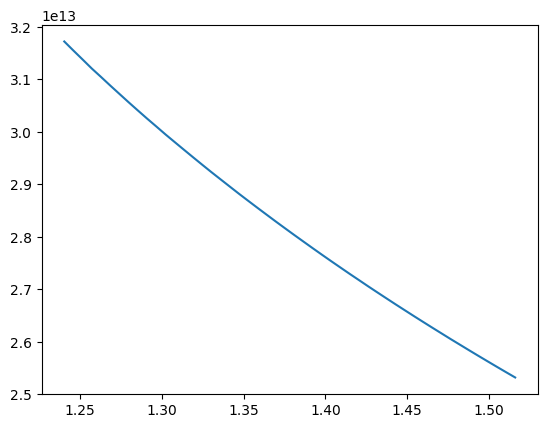

In [11]:
plt.plot(plasma_dof_0_list, f_K_test_list)

In [12]:
f_max_Phi_diff_test_list[5]

Array(-495875.25, dtype=float32)

Max error: 4760.8438
Avg error: 1262.6044


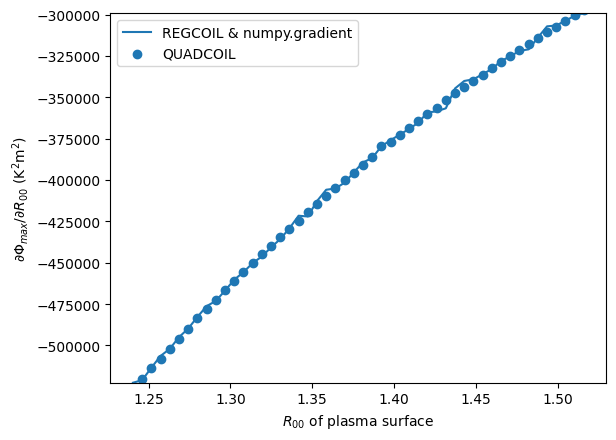

In [13]:
grad_f_max_Phi = jnp.gradient(f_max_Phi_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_max_Phi, label='REGCOIL & numpy.gradient')
plt.scatter(plasma_dof_0_list, f_max_Phi_diff_test_list, label='QUADCOIL')
# plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list2, label='QUADCOIL2', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial \Phi_{max}/\partial R_{00}$ (K$^2$m$^2$)')
plt.ylim(jnp.min(grad_f_max_Phi), jnp.max(grad_f_max_Phi))
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_max_Phi - f_max_Phi_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_max_Phi - f_max_Phi_diff_test_list)))

Max error: 887338570000.0
Avg error: 228160700000.0


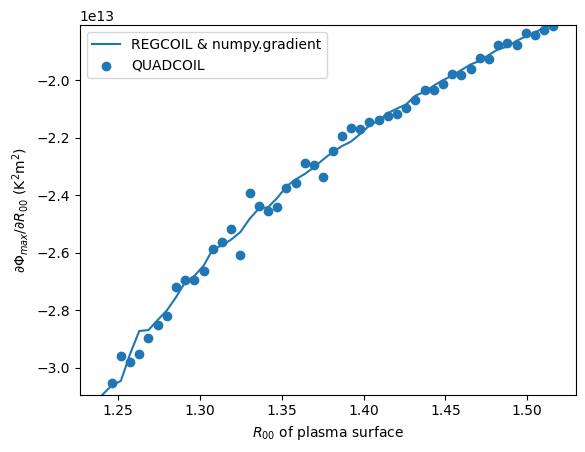

In [14]:
grad_f_K = jnp.gradient(f_K_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_K, label='REGCOIL & numpy.gradient')
plt.scatter(plasma_dof_0_list, f_K_diff_test_list, label='QUADCOIL')
# plt.plot(plasma_dof_0_list, f_K_diff_test_list2, label='QUADCOIL2', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial \Phi_{max}/\partial R_{00}$ (K$^2$m$^2$)')
plt.ylim(jnp.min(grad_f_K), jnp.max(grad_f_K))
# plt.yscale('log')
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_K - f_K_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_K - f_K_diff_test_list)))

In [15]:
jnp.save('breaking_params2', {
    'nfp': plasma_surface.nfp,
    'stellsym': plasma_surface.stellsym,
    'plasma_coil_distance': separation,
    'mpol': mpol,
    'ntor': ntor,
    'plasma_dofs': plasma_dof_i,
    'plasma_mpol': plasma_surface.mpol,
    'plasma_ntor': plasma_surface.ntor,
    'net_poloidal_current_amperes': net_poloidal_current_amperes,
    'net_toroidal_current_amperes': 0.,
    'metric_name': ('f_max_Phi', 'f_K', 'f_B'),
    'objective_name': 'f_max_Phi2', # Minimizing peak dipole density
    'objective_unit': unit_Phi2, # under an f_B constraint
    'constraint_name': ('f_B',),
    'constraint_type': ('<=',),
    'constraint_unit': (f_B_target,),
    'constraint_value': np.array([f_B_target,]),
    'verbose': 1
})